Implementing the code described at http://nbviewer.jupyter.org/github/metamath1/ml-simple-works/blob/master/GAN/GANs.ipynb?flush_cache=true

In [53]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import optimizers
from keras.utils import np_utils



In [54]:

#np.random.seed(78)
#np.random.seed(0)

batch_size = 200
print_interval = 500

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val



학습 데이터를 생성한다. 

In [55]:
mu, sigma = 6, 1.25

def get_distribution_sampler(mu,sigma,N):
    data_xp, data_yp = np.random.normal(mu,sigma,N), np.ones(N)
    data_p = np.vstack((data_xp,data_yp)).T

    return data_p



In [56]:

D = Sequential()
D.add(Dense(30,activation='relu', input_dim = 1))
D.add(Dense(30,activation='relu'))
D.add(Dense(2,activation='softmax'))
D_opt = optimizers.Adam(lr=0.001*1.58, beta_1=0.9,beta_2=0.999, epsilon=1e-08,decay=0.0)
D.compile(loss='binary_crossentropy',optimizer=D_opt, metrics=['accuracy'])
D.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 30)                60        
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 62        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Generator 

G = Sequential()
G.add(Dense(20, input_dim=1))
G.add(Activation('sigmoid'))
G.add(Dense(40))
G.add(Activation('sigmoid'))
G.add(Dense(1))
G.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 20)                40        
_________________________________________________________________
activation_5 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                840       
_________________________________________________________________
activation_6 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 41        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


In [58]:

# GAN - phase 1 --- D(G(z))

make_trainable(D,False)
gan_input = Input(shape=[1])
GAN = Model ( gan_input, D(G(gan_input)))
G_opt = optimizers.Adam(lr=0.001*1.1, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08,decay=0.0)
GAN.compile(loss='mean_squared_logarithmic_error', optimizer=G_opt)
GAN.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 921       
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 1052      
Total params: 1,973
Trainable params: 921
Non-trainable params: 1,052
_________________________________________________________________


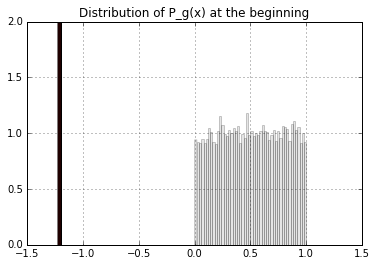

G produced value 10개
[[-1.210518  ]
 [-1.20624578]
 [-1.21403754]
 [-1.22800124]
 [-1.22299385]
 [-1.21321929]
 [-1.20264435]
 [-1.19919097]
 [-1.20333135]
 [-1.21975744]]


In [59]:

Z1 = np.random.uniform(0,1,10000)
fake1 = G.predict(Z1)
n, bins1, patches = plt.hist(Z1, 50 , normed=1, facecolor='grey', alpha=0.2)
plt.title('Distribution of P_g(x) at the beginning')
n, bins, patches = plt.hist(fake1, 50, normed=1, facecolor='red', alpha=0.5)
plt.grid(True)
plt.axis([-1.5,1.5,0,2])
plt.show()
print("G produced value 10개")
print(fake1[:10])


Discriminator 를 미리 한번 학습시켜본다.. 

In [60]:
make_trainable(D,True)

k = 200
real_mb = get_distribution_sampler(mu,sigma,batch_size * k)
fake_mb = np.hstack ( 
        (G.predict(np.random.uniform(0,1,batch_size*k)),
                    np.zeros(batch_size*k).reshape(batch_size*k,1)))

#print(real_mb)
#print(fake_mb)

train_D = np.vstack((real_mb,fake_mb))
train_D = train_D[ np.random.permutation( train_D.shape[0]),:]
train_Dx = train_D[:,0]
train_Dy = np_utils.to_categorical(train_D[:,1],2)

D.fit(train_Dx,train_Dy, epochs=2, batch_size=batch_size)

Z = np.concatenate( (real_mb[:5,0],fake_mb[:5,0]))

detec = D.predict(Z)

print(np.hstack((Z.reshape(10,1),detec)))


Epoch 1/2
80000/80000 [==============================] - 0s - loss: 0.0643 - acc: 0.9739          

여기까지 한걸 요약하면 간단하게 ..... G, D 를 만들고, real, fake sample data 들을 생성한 다음에, D 를 그 값을 통해서 한번 학습을 시켜본거임....  자 이제부터 Detector 세번학습시키는 동안 Generator 한번 학습시켜서 G 를 D distribution 안에 fitting 시키는 과정을 하는 것임 

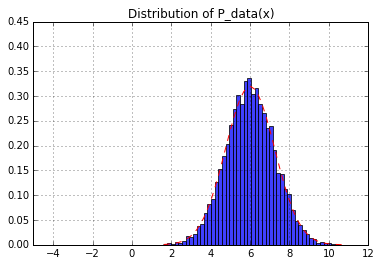

In [61]:

# the histogram of the data

plt.title('Distribution of P_data(x)')
n, bins1, patches = plt.hist( get_distribution_sampler(mu,sigma,10000)[:,0] ,50, normed=1,facecolor='blue', alpha=0.75)
y = mlab.normpdf(bins1,mu,sigma)
l = plt.plot(bins1,y,'r--', linewidth=1)
plt.axis([-5,12,0,0.45])
plt.grid(True)
plt.show()


 Epoch : 0, D: [0.0001818937, 0.99999994], G loss : 0.4803704619407654


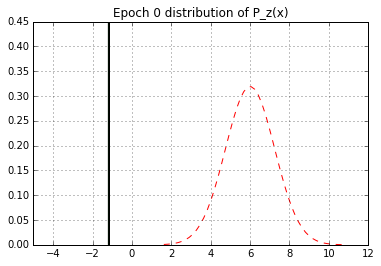

 Epoch : 500, D: [0.3073374, 0.8775], G loss : 0.32463139295578003
 Epoch : 1000, D: [0.61866516, 0.62249994], G loss : 0.18186432123184204


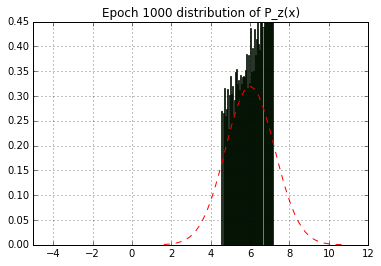

 Epoch : 1500, D: [0.6773048, 0.54000002], G loss : 0.13699963688850403
 Epoch : 2000, D: [0.62827057, 0.65249997], G loss : 0.15250442922115326


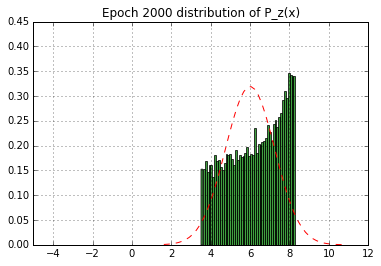

 Epoch : 2500, D: [0.64774883, 0.61499995], G loss : 0.12518784403800964
 Epoch : 3000, D: [0.6310699, 0.60999995], G loss : 0.1409429907798767


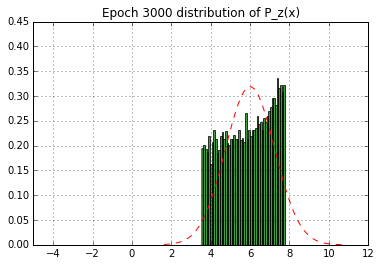

 Epoch : 3500, D: [0.66492593, 0.60749996], G loss : 0.15660713613033295
 Epoch : 4000, D: [0.63507974, 0.62499994], G loss : 0.13519854843616486


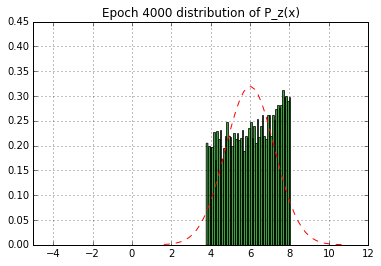

 Epoch : 4500, D: [0.64553154, 0.60249996], G loss : 0.12974916398525238
 Epoch : 5000, D: [0.65623385, 0.57000005], G loss : 0.1350211650133133


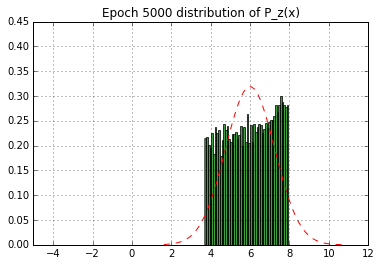

 Epoch : 5500, D: [0.63709402, 0.62], G loss : 0.1616932898759842
 Epoch : 6000, D: [0.63828385, 0.55999994], G loss : 0.16539651155471802


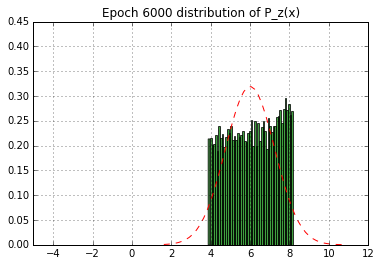

 Epoch : 6500, D: [0.62606817, 0.625], G loss : 0.13951365649700165
 Epoch : 7000, D: [0.63491714, 0.60999995], G loss : 0.14595341682434082


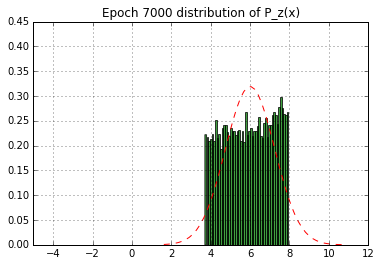

 Epoch : 7500, D: [0.6487698, 0.58749998], G loss : 0.1508721113204956
 Epoch : 8000, D: [0.63705808, 0.63749999], G loss : 0.13722233474254608


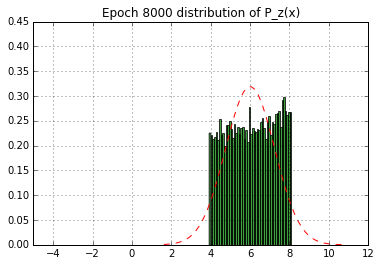

 Epoch : 8500, D: [0.64008671, 0.60249996], G loss : 0.15230587124824524
 Epoch : 9000, D: [0.65169591, 0.58749998], G loss : 0.15016238391399384


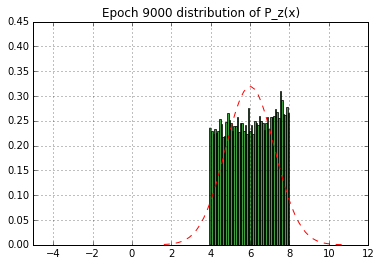

 Epoch : 9500, D: [0.63775808, 0.59999996], G loss : 0.14260493218898773
 Epoch : 10000, D: [0.62991732, 0.61500001], G loss : 0.15699970722198486


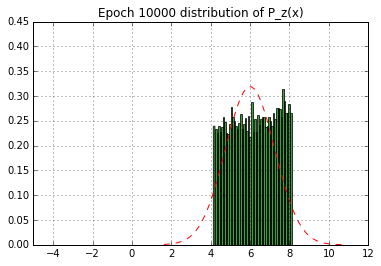

 Epoch : 10500, D: [0.6420384, 0.61999995], G loss : 0.13599856197834015
 Epoch : 11000, D: [0.62942815, 0.59749997], G loss : 0.14793863892555237


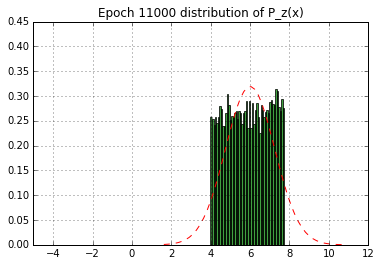

 Epoch : 11500, D: [0.63063419, 0.60999995], G loss : 0.15721778571605682
 Epoch : 12000, D: [0.64581192, 0.60499996], G loss : 0.1561814695596695


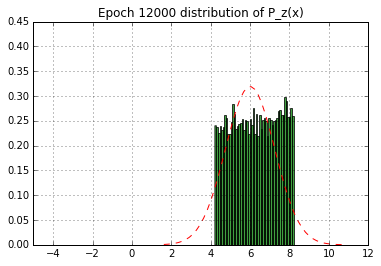

 Epoch : 12500, D: [0.63203394, 0.60999995], G loss : 0.16871175169944763
 Epoch : 13000, D: [0.65361679, 0.55749995], G loss : 0.16040708124637604


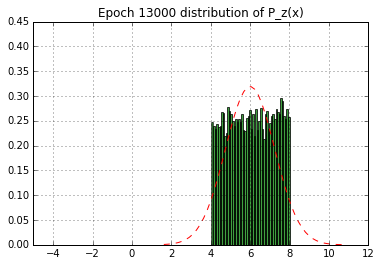

 Epoch : 13500, D: [0.63963985, 0.59749997], G loss : 0.14023321866989136
 Epoch : 14000, D: [0.64785713, 0.58749992], G loss : 0.1413610577583313


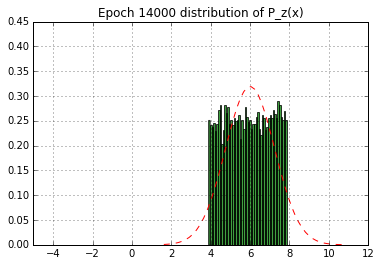

 Epoch : 14500, D: [0.64458174, 0.57249993], G loss : 0.13843956589698792
 Epoch : 15000, D: [0.63647532, 0.58999997], G loss : 0.1495404988527298


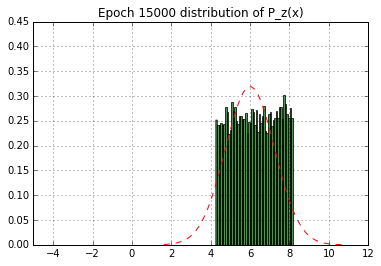

 Epoch : 15500, D: [0.63535082, 0.61000001], G loss : 0.14226184785366058
 Epoch : 16000, D: [0.63871384, 0.60999995], G loss : 0.1610497385263443


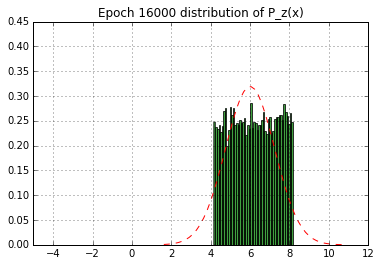

 Epoch : 16500, D: [0.63551551, 0.58749998], G loss : 0.1467275768518448
 Epoch : 17000, D: [0.65488321, 0.58499998], G loss : 0.14762663841247559


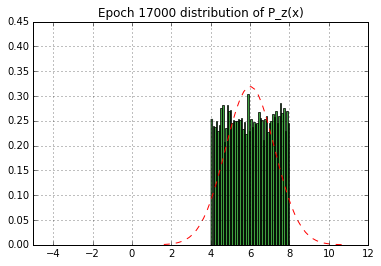

 Epoch : 17500, D: [0.63947856, 0.58499998], G loss : 0.14382830262184143
 Epoch : 18000, D: [0.62603682, 0.59999996], G loss : 0.1489153951406479


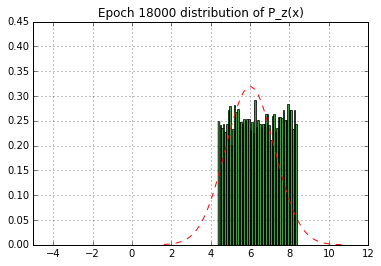

 Epoch : 18500, D: [0.63636363, 0.59749991], G loss : 0.14531463384628296
 Epoch : 19000, D: [0.64338219, 0.61749995], G loss : 0.1379416435956955


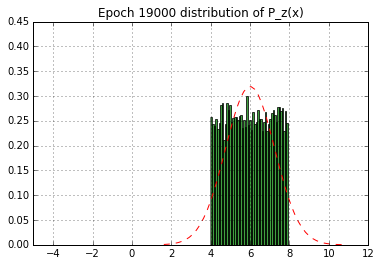

 Epoch : 19500, D: [0.63747227, 0.58249998], G loss : 0.1421927511692047
 Epoch : 20000, D: [0.63502932, 0.5675], G loss : 0.15491893887519836


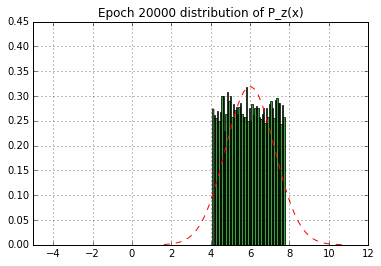

 Epoch : 20500, D: [0.63369817, 0.55749995], G loss : 0.14408992230892181
 Epoch : 21000, D: [0.62919033, 0.60249996], G loss : 0.13544175028800964


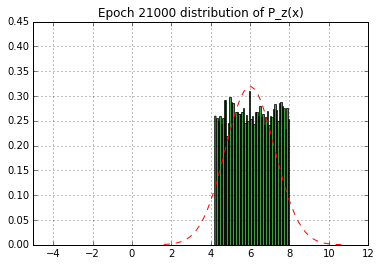

 Epoch : 21500, D: [0.64756417, 0.58499998], G loss : 0.15191322565078735
 Epoch : 22000, D: [0.63510364, 0.59249997], G loss : 0.14232097566127777


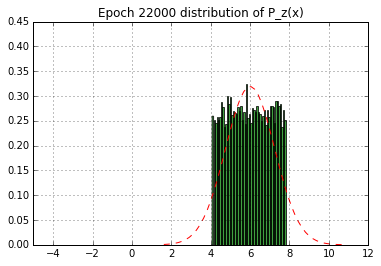

 Epoch : 22500, D: [0.63866055, 0.59999996], G loss : 0.14876310527324677
 Epoch : 23000, D: [0.65714294, 0.59749997], G loss : 0.14780530333518982


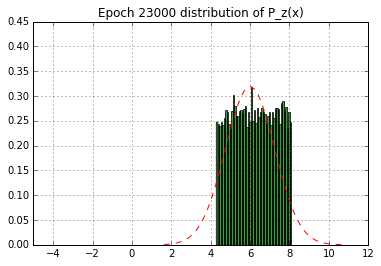

 Epoch : 23500, D: [0.64061403, 0.61750001], G loss : 0.13842344284057617
 Epoch : 24000, D: [0.6247651, 0.61250001], G loss : 0.16123613715171814


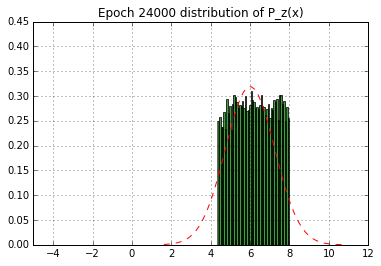

 Epoch : 24500, D: [0.63747603, 0.57749999], G loss : 0.14694096148014069
 Epoch : 25000, D: [0.64781761, 0.57249999], G loss : 0.14856061339378357


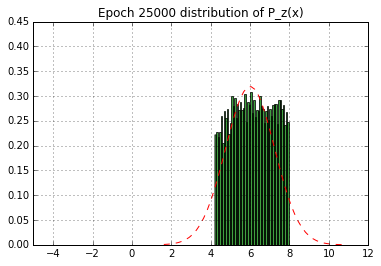

 Epoch : 25500, D: [0.63452947, 0.58249998], G loss : 0.1481628566980362
 Epoch : 26000, D: [0.6529811, 0.61250001], G loss : 0.13880816102027893


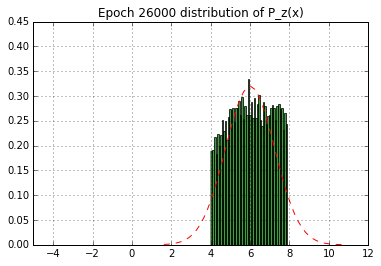

 Epoch : 26500, D: [0.64390981, 0.56999999], G loss : 0.13860014081001282
 Epoch : 27000, D: [0.64534223, 0.55249995], G loss : 0.14354969561100006


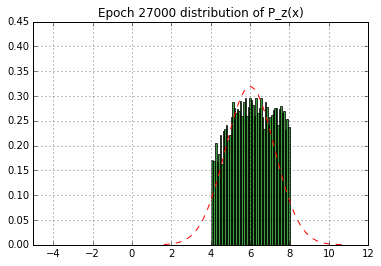

 Epoch : 27500, D: [0.63988566, 0.61249995], G loss : 0.13716818392276764
 Epoch : 28000, D: [0.65645146, 0.56249994], G loss : 0.14049893617630005


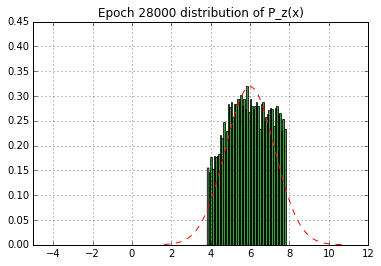

 Epoch : 28500, D: [0.66523302, 0.4975], G loss : 0.13234680891036987
 Epoch : 29000, D: [0.6398778, 0.53499997], G loss : 0.13594350218772888


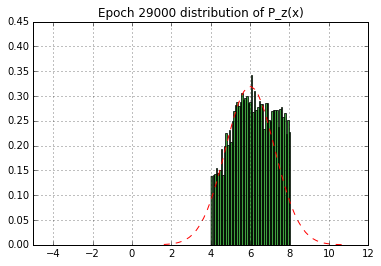

 Epoch : 29500, D: [0.67316109, 0.52499998], G loss : 0.14249055087566376
 Epoch : 30000, D: [0.66026062, 0.55500001], G loss : 0.1493014246225357


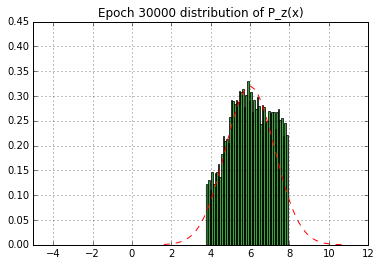

 Epoch : 30500, D: [0.65084553, 0.56749994], G loss : 0.13944695889949799
 Epoch : 31000, D: [0.65865284, 0.54999995], G loss : 0.13467280566692352


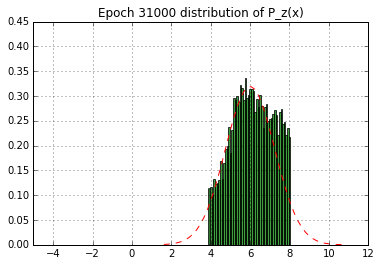

 Epoch : 31500, D: [0.65546972, 0.57750005], G loss : 0.1404678374528885
 Epoch : 32000, D: [0.66518795, 0.56], G loss : 0.13863025605678558


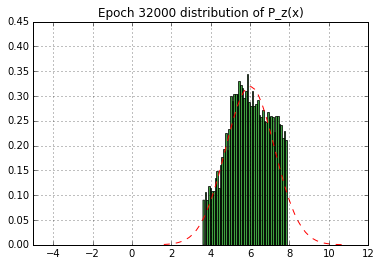

 Epoch : 32500, D: [0.64026022, 0.54499996], G loss : 0.13532696664333344
 Epoch : 33000, D: [0.66383159, 0.53499997], G loss : 0.14200203120708466


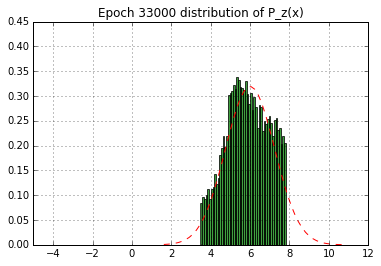

 Epoch : 33500, D: [0.65986228, 0.53749996], G loss : 0.13553516566753387
 Epoch : 34000, D: [0.66803223, 0.53999996], G loss : 0.13889886438846588


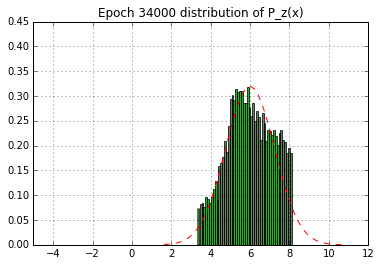

 Epoch : 34500, D: [0.66383904, 0.53999996], G loss : 0.1328398883342743
 Epoch : 35000, D: [0.65948027, 0.5575], G loss : 0.12794330716133118


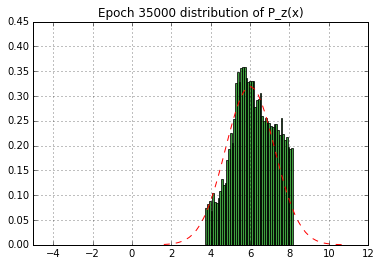

 Epoch : 35500, D: [0.66365671, 0.54499996], G loss : 0.1291896104812622
 Epoch : 36000, D: [0.67949057, 0.52749997], G loss : 0.12802693247795105


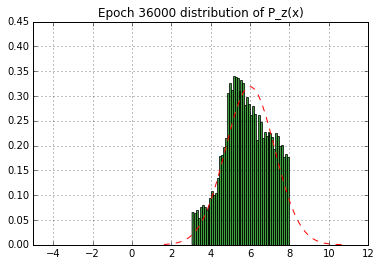

 Epoch : 36500, D: [0.67878109, 0.52999997], G loss : 0.13485699892044067
 Epoch : 37000, D: [0.66913122, 0.54749995], G loss : 0.13262313604354858


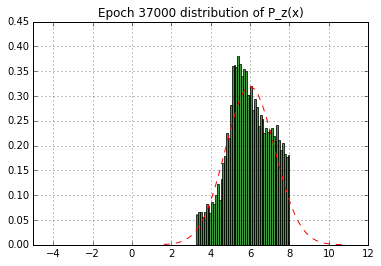

 Epoch : 37500, D: [0.67906016, 0.51499999], G loss : 0.1281137466430664
 Epoch : 38000, D: [0.69976407, 0.51749998], G loss : 0.13489575684070587


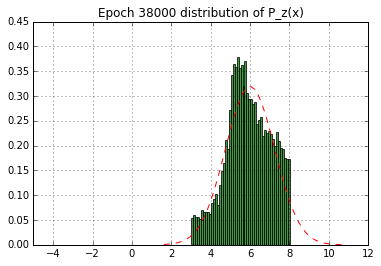

 Epoch : 38500, D: [0.67504406, 0.53249997], G loss : 0.13247540593147278
 Epoch : 39000, D: [0.68652701, 0.54250002], G loss : 0.13415540754795074


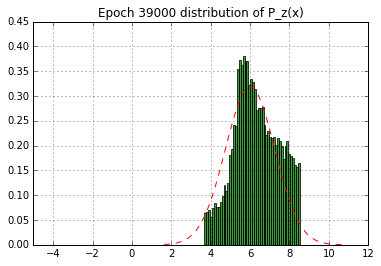

 Epoch : 39500, D: [0.69874769, 0.46000001], G loss : 0.12865395843982697
 Epoch : 40000, D: [0.68286228, 0.51749998], G loss : 0.12613636255264282


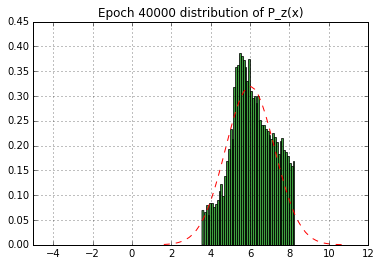

 Epoch : 40500, D: [0.66842902, 0.53750002], G loss : 0.12443371117115021
 Epoch : 41000, D: [0.66765106, 0.57249999], G loss : 0.12688174843788147


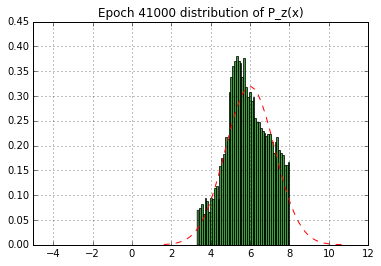

 Epoch : 41500, D: [0.67885232, 0.51249999], G loss : 0.13434632122516632
 Epoch : 42000, D: [0.65342706, 0.60500002], G loss : 0.13609905540943146


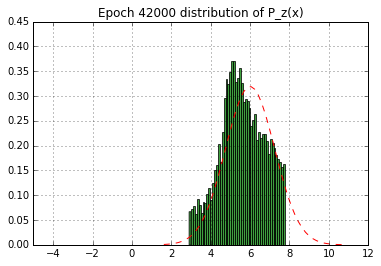

 Epoch : 42500, D: [0.68500888, 0.48999995], G loss : 0.1271570324897766
 Epoch : 43000, D: [0.66577667, 0.58499992], G loss : 0.13064739108085632


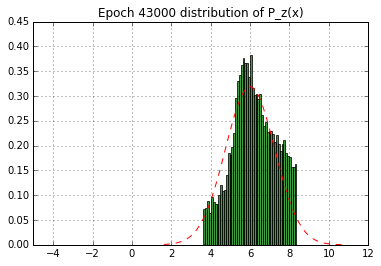

 Epoch : 43500, D: [0.66043276, 0.53749996], G loss : 0.1370341181755066
 Epoch : 44000, D: [0.65856171, 0.53499997], G loss : 0.12647713720798492


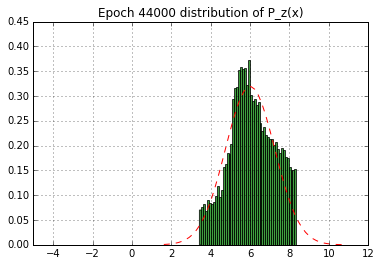

 Epoch : 44500, D: [0.67734772, 0.52499998], G loss : 0.13229447603225708


In [62]:

np_epoch = 45000
D_losses = []
GAN_losses = []

for epoch in range(np_epoch):

    for k in range(3):
        real_mb = get_distribution_sampler(mu,sigma,batch_size)
        fake_mb = np.hstack(
                    ( G.predict( np.random.uniform(0,1,batch_size)),
                        np.zeros(batch_size).reshape(batch_size,1))
                )
        train_D = np.vstack((real_mb, fake_mb))
        train_D = train_D[ np.random.permutation(train_D.shape[0]),:]
        train_Dx = train_D[:,0]
        train_Dy = np_utils.to_categorical(train_D[:,1],2)
        d_loss = D.train_on_batch(train_Dx,train_Dy)
        D_losses.append(d_loss)


    g_loss = GAN.train_on_batch( np.random.uniform(0,1,batch_size) , np_utils.to_categorical(np.ones(batch_size),2) )
    GAN_losses.append(g_loss)

    if epoch % print_interval == 0:
        print(" Epoch : {}, D: {}, G loss : {}".format(epoch,d_loss,g_loss))

    if epoch % 1000 == 0:
        fake = G.predict(Z1)
        plt.title('Epoch {} distribution of P_z(x)'.format(epoch))
        plt.hist(fake,50, normed=1, facecolor='green',alpha=0.75)
        l = plt.plot(bins1,y,'r--',linewidth=1)
        plt.axis([-5,12,0,0.45])
        plt.grid(True)
        plt.show()


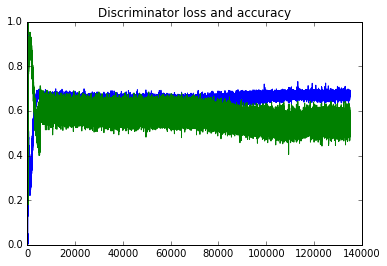

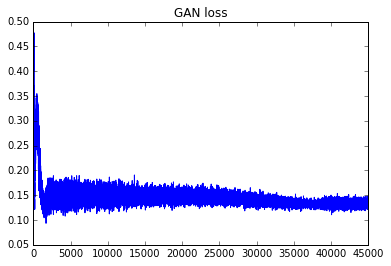

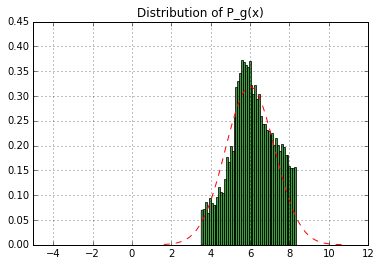

[[ 6.2343502 ]
 [ 6.72089767]
 [ 5.90045309]
 [ 3.59995294]
 [ 4.99944782]
 [ 5.97412395]
 [ 7.22721958]
 [ 7.81494284]
 [ 7.12272215]
 [ 5.39772511]]


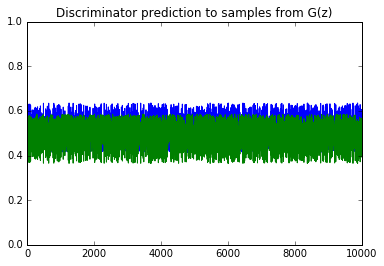

[[ 0.49429053  0.50570947]
 [ 0.4702175   0.52978241]
 [ 0.51648891  0.48351109]
 [ 0.51620859  0.4837915 ]
 [ 0.46763641  0.53236359]
 [ 0.51159358  0.48840648]
 [ 0.47668013  0.52331984]
 [ 0.56210375  0.43789631]
 [ 0.47534564  0.52465439]
 [ 0.49348474  0.50651532]]


In [63]:
plt.title('Discriminator loss and accuracy')    
plt.plot(D_losses)
plt.show()

plt.title('GAN loss')    
plt.plot(GAN_losses)
plt.show()

fake = G.predict(Z1)
plt.title('Distribution of P_g(x)')
plt.hist(fake, 50, normed=1, facecolor='green', alpha=0.75)
l = plt.plot(bins1, y, 'r--', linewidth=1)
plt.axis([-5, 12, 0, 0.45])
plt.grid(True)
plt.show()
print(fake[:10])

plt.title('Discriminator prediction to samples from G(z)')
detec = D.predict(fake)
plt.plot(detec)
plt.axis([0, 10000, 0, 1])
plt.show()
print(detec[:10])

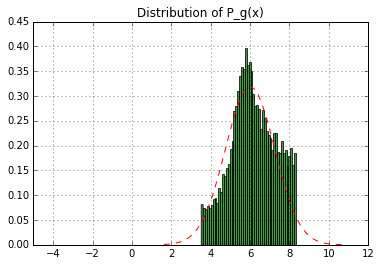

In [64]:
plt.title('Distribution of P_g(x)')
plt.hist(G.predict(np.random.uniform(0,1,10000)), 50, normed=1, facecolor='green', alpha=0.75)
l = plt.plot(bins1, y, 'r--', linewidth=1)
plt.axis([-5, 12, 0, 0.45])
plt.grid(True)
plt.show()
